In [1]:
import IO
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
K.set_image_data_format('channels_first') # IMPORTANT, otherwise eegnet wont work with input shape!


# custom definition of cost fct.
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r2_keras_sk(y_true, y_pred): # does NOT work in this context
    return metrics.r2_score(y_true, y_pred)

def EEGNet(Chans = 6, Samples = 1000, 
             dropoutRate = 0.5, kernLength = 400, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    #softmax      = Activation('softmax', name = 'softmax')(dense)
    
    linear      = Activation('linear', name = 'linear')(dense)
    
    return Model(inputs=input1, outputs=linear)

### read combined ECOG data paient 0 

In [2]:
# BIDS path
PATH = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\"

In [3]:
vhdr_files = IO.get_all_vhdr_files(PATH)

In [4]:
sub = "000"
sess = "right"
f_ = [file for file in vhdr_files if sub in file and sess in file]
idx = 0
for f in f_:
    if idx == 0:
        idx = 1
        dat_ = IO.read_BIDS_file(os.path.join(PATH, f))[0][-10:,:]
    else:
        dat_ = np.concatenate((dat_, IO.read_BIDS_file(os.path.join(PATH, f))[0][-10:,:]), axis=1)

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...


In [5]:
def generator(features, labels, batch_size): 
    
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros([batch_size, 1, 6, kernLength])
    batch_labels = np.zeros([batch_size]) 
    
    while True:
        for idx_label in np.arange(1000, features.shape[0]-batch_size, batch_size): 
            for i in range(batch_size):

                for ch in range(6):
                    batch_features[i,0,ch,:] = features[(idx_label+i-kernLength):i+idx_label,ch]
                batch_labels[i] = labels[idx_label+i]

            yield batch_features, batch_labels, [None]

#### clear GPU memory, necessary when kernel is interrupted

In [6]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

#### define train, test, val sets

In [7]:
### first, define data as in https://github.com/vlawhern/arl-eegmodels
# for that, downsample data to 100Hz

X = dat_[:6,::10].T # 6 channels, here downsampled to 500Hz!
y_con = dat_[-1,::10] # read cleaned movement labels 
y_ips = dat_[-2,::10]
chans=6

X_train, X_test, y_train, y_test = train_test_split(X, y_con, train_size=0.7,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

In [8]:
X_train.shape

(37289, 6)

#### model definition

Here 6 channels are used. The generator is used to get data, which is sampled into trials. 

Samples is here the sampling frequency, kernLength I set here also to 500 (f_c = 250Hz). 

model.fit: steps per epoch: how many times the generator is called (for train and val). 
This should cover ~ the training dataset.  

In [20]:
kernLength = 100 # half of fs
model  = EEGNet(Chans = 6, Samples = 100, kernLength=kernLength)
model.compile(loss = 'mse', optimizer = 'adam', metrics=["mean_squared_error"])

In [25]:
batch_size = 300
int(X_train.shape[0]/batch_size)

124

In [26]:

es = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_mean_squared_error', mode='min', verbose=1, save_best_only=True)

with tf.device('/gpu:0'):
    gen_tr = generator(X_train, y_train, batch_size)
    gen_val = generator(X_val, y_val, batch_size)
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])

Train for 124 steps, validate for 53 steps
Epoch 1/100
123/124 [============================>.] - ETA: 0s - loss: 0.0417 - mean_squared_error: 0.0417
Epoch 00001: val_mean_squared_error improved from inf to 0.03374, saving model to best_model.h5
124/124 [==============================] - 65s 521ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 2/100
120/124 [============================>.] - ETA: 0s - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 00002: val_mean_squared_error improved from 0.03374 to 0.02564, saving model to best_model.h5
124/124 [==============================] - 2s 19ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 3/100
120/124 [============================>.] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 00003: val_mean_squared_error did not improve from 0.02564
124/124 [==============================] - 2s 19ms/step - loss: 0.034

120/124 [============================>.] - ETA: 0s - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 00025: val_mean_squared_error did not improve from 0.01984
124/124 [==============================] - 2s 18ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 26/100
120/124 [============================>.] - ETA: 0s - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 00026: val_mean_squared_error did not improve from 0.01984
124/124 [==============================] - 2s 18ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 27/100
120/124 [============================>.] - ETA: 0s - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 00027: val_mean_squared_error did not improve from 0.01984
124/124 [==============================] - 2s 18ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 28/100
122/124 [================

In [27]:
model = load_model('best_model.h5', custom_objects={'r2_keras': r2_keras})

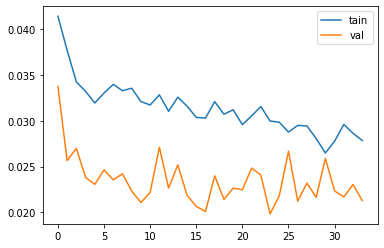

In [28]:
plt.plot(hist.history["loss"], label="tain")
plt.plot(hist.history["val_loss"], label="val")
plt.legend()
plt.show()

In [29]:
def get_label_from_gen(gen_, X_):
    for i in range(int(X_.shape[0]/500)):
        if i == 0:
            arr = np.array(next(gen_)[1])
        else:
            arr = np.concatenate((arr, next(gen_)[1]), axis=0)
    return arr

In [30]:
gen_ = generator(X_train, y_train, 500)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/500))[:,0]
gen_ = generator(X_train, y_train, 500)
y_train_ = get_label_from_gen(gen_, X_train)

Text(0.5, 1.0, 'train sub000 con. $R^2$0.19')

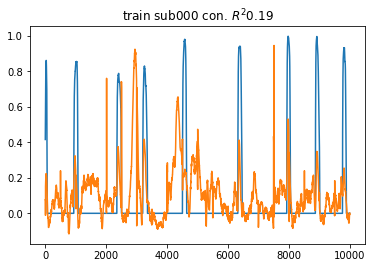

In [31]:
plt.plot(y_train_[:10000])
plt.plot(pr_train[:10000])
plt.title("train sub000 con. "+r"$R^2$" + str(np.round(metrics.r2_score(y_train_, pr_train),2)))

In [32]:
from scipy import stats

In [33]:
stats.spearmanr(y_train_, pr_train)

SpearmanrResult(correlation=0.3711764416283755, pvalue=0.0)

In [34]:
gen_ = generator(X_test, y_test, 500)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/500))[:,0]
gen_ = generator(X_test, y_test, 500)
y_test_ = get_label_from_gen(gen_, X_test)

Text(0.5, 1.0, 'test sub000 con. $R^2$=0.44')

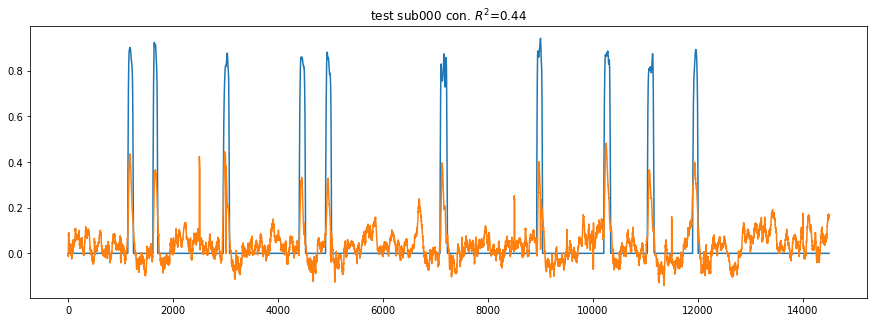

In [35]:
plt.figure(figsize=(15,5))
plt.plot(y_test_[8000:])
plt.plot(pr_test[8000:])
plt.title("test sub000 con. "+r"$R^2$" + "="+str(np.round(metrics.r2_score(y_test_, pr_test),2)))

In [36]:
stats.spearmanr(y_test_, pr_test)

SpearmanrResult(correlation=0.4387534286256294, pvalue=0.0)

### now use method with gamma band filter

In [49]:
X = dat_[:6,::2].T # 6 channels, here downsampled to 500Hz!
y_con = dat_[-1,::2] # read cleaned movement labels 
y_ips = dat_[-2,::2]
chans=6

X_train, X_test, y_train, y_test = train_test_split(X, y_con, train_size=0.7,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

In [50]:
kernLength = 500 # half of fs
model  = EEGNet(Chans = 6, Samples = 500, kernLength=kernLength)
model.compile(loss = 'mse', optimizer = 'adam', metrics=["mean_squared_error"])

In [52]:
batch_size = 300
int(X_train.shape[0]/batch_size)

621

In [53]:

es = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_mean_squared_error', mode='min', verbose=1, save_best_only=True)

with tf.device('/gpu:0'):
    gen_tr = generator(X_train, y_train, batch_size)
    gen_val = generator(X_val, y_val, batch_size)
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])

Train for 621 steps, validate for 266 steps
Epoch 1/100
619/621 [============================>.] - ETA: 0s - loss: 0.0533 - mean_squared_error: 0.0533
Epoch 00001: val_mean_squared_error improved from inf to 0.03616, saving model to best_model.h5
621/621 [==============================] - 23s 37ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 2/100
619/621 [============================>.] - ETA: 0s - loss: 0.0459 - mean_squared_error: 0.0459
Epoch 00002: val_mean_squared_error did not improve from 0.03616
621/621 [==============================] - 22s 36ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 3/100
619/621 [============================>.] - ETA: 0s - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 00003: val_mean_squared_error did not improve from 0.03616
621/621 [==============================] - 22s 36ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - 

In [54]:
model = load_model('best_model.h5', custom_objects={'r2_keras': r2_keras})

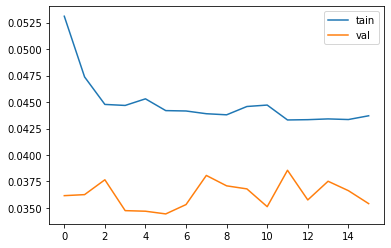

In [55]:
plt.plot(hist.history["loss"], label="tain")
plt.plot(hist.history["val_loss"], label="val")
plt.legend()
plt.show()

In [56]:
gen_ = generator(X_train, y_train, 500)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/500))[:,0]
gen_ = generator(X_train, y_train, 500)
y_train_ = get_label_from_gen(gen_, X_train)

Text(0.5, 1.0, 'train sub000 con. $R^2$-0.04')

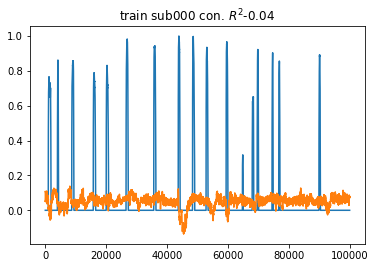

In [58]:
plt.plot(y_train_[:100000])
plt.plot(pr_train[:100000])
plt.title("train sub000 con. "+r"$R^2$" + str(np.round(metrics.r2_score(y_train_, pr_train),2)))

In [59]:
gen_ = generator(X_test, y_test, 500)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/500))[:,0]
gen_ = generator(X_test, y_test, 500)
y_test_ = get_label_from_gen(gen_, X_test)

Text(0.5, 1.0, 'test sub000 con. $R^2$=-0.01')

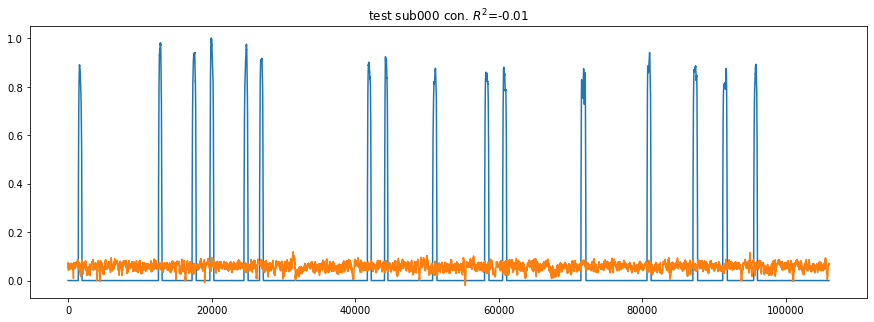

In [60]:
plt.figure(figsize=(15,5))
plt.plot(y_test_[8000:])
plt.plot(pr_test[8000:])
plt.title("test sub000 con. "+r"$R^2$" + "="+str(np.round(metrics.r2_score(y_test_, pr_test),2)))

In [37]:
from deepexplain.tensorflow import DeepExplain

AttributeError: module 'tensorflow' has no attribute 'get_default_session'

In [239]:
30*450/2

6750.0